In [1]:
%matplotlib inline
import numpy
import pandas
import matplotlib.pyplot as plt

import os, sys
sys.path.append('../code')

# Generate events

In [289]:
from utils import straight_tracks_generator
events = straight_tracks_generator(n_events=100, n_tracks=3, n_noise=5, sigma=0.01, 
                                   intersection=False, x_range=(0, 10, 1), y_range=(-30, 30, 2))

# Tracks Recognition

In [290]:
event = events[events.EventID == 0]
X = event.X.values.reshape(-1,1)
y = event.y.values

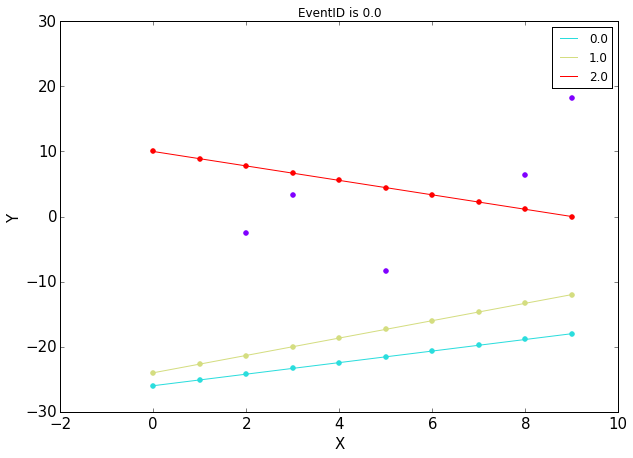

In [291]:
from utils import plot_straight_tracks
plot_straight_tracks(event)
#plt.xlim(-0.5, 9.5)
plt.ylabel('Y', size=15)
plt.xlabel('X', size=15)
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

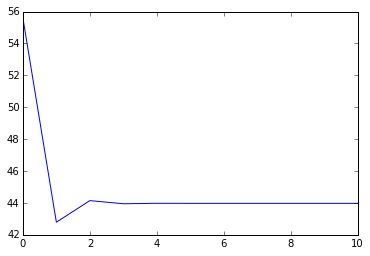

In [305]:
from DenbyPeterson import DenbyPeterson, cut_neurons, find_tracks, plot_neural_net, cut_labels

dp = DenbyPeterson(n_iter=10, 
                   cos_degree=1, 
                   alpha=0.00, 
                   delta=0.00, 
                   temperature=1, 
                   temperature_decay_rate=1., 
                   save_stages=True)
states = dp.fit(X, y)
states_after_cut = cut_neurons(X, y, states, -0.9, 0.5)
labels = find_tracks(states_after_cut, 0.5)
labels = cut_labels(labels, min_hits=3)

states_stages = dp.states_stages_
energy_stages = dp.energy_stages_

plt.plot(energy_stages)
plt.show()

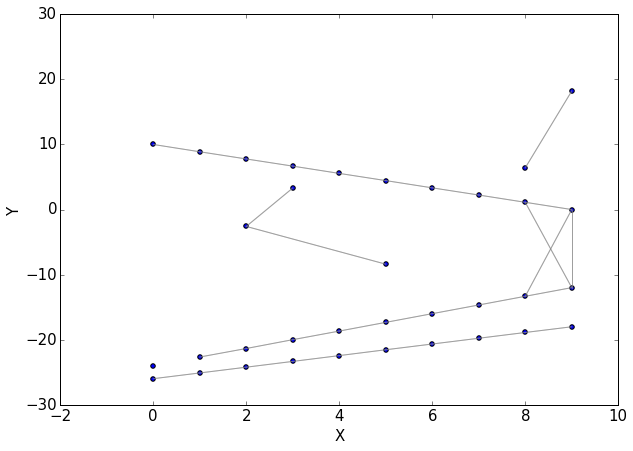

In [306]:
states_id = 10
plot_neural_net(X, y, states_stages[states_id], 0.5)  
plt.show()

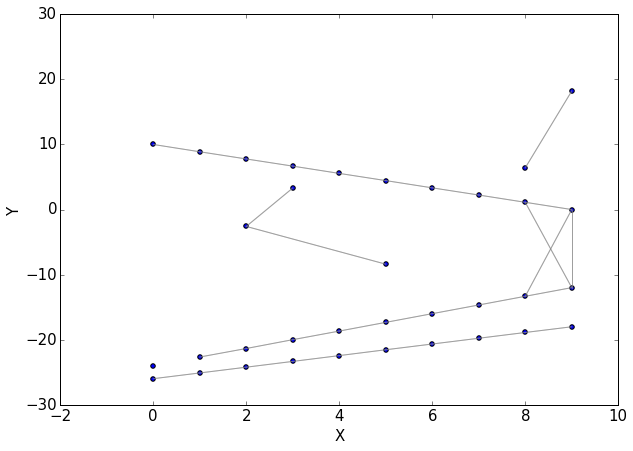

In [307]:
plot_neural_net(X, y, states, 0.5)   
plt.show()

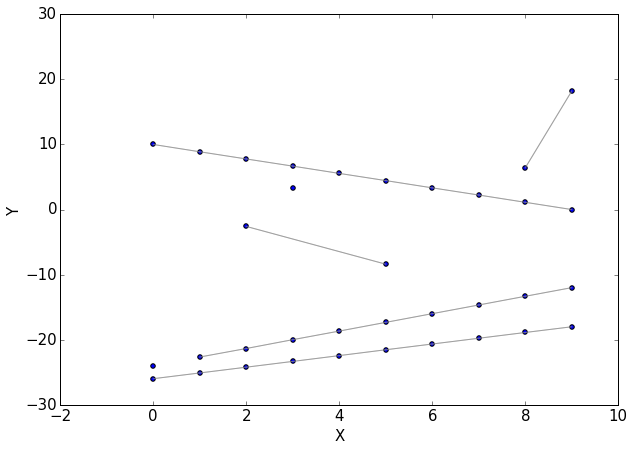

In [308]:
plot_neural_net(X, y, states_after_cut, 0.5)
plt.show()

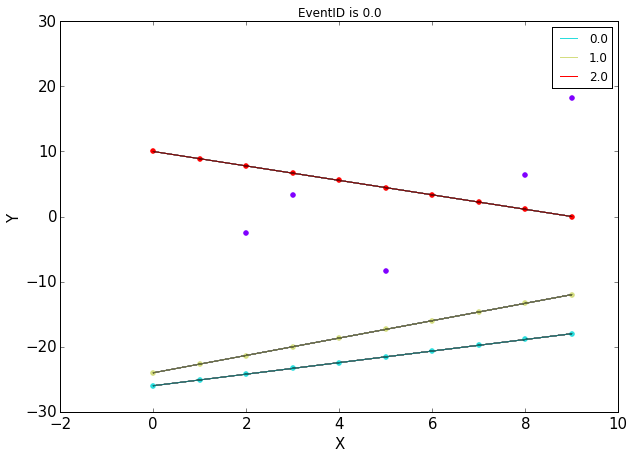

In [300]:
from utils import plot_straight_tracks
plot_straight_tracks(event, labels)
plt.ylabel('Y', size=15)
plt.xlabel('X', size=15)
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

# Tracks Reconstruction Quality

## Hits Matching

In [301]:
from metrics import HitsMatchingEfficiency

hme = HitsMatchingEfficiency()
hme.fit(event, labels)

print hme.efficiencies_
print hme.avg_efficiency_
print hme.recognition_efficiency_
print hme.ghost_rate_
print hme.clone_rate_

[ 1.  1.  1.]
1.0
1.0
0.0
0.0


## Parameters Matching

In [302]:
from metrics import ParameterMatchingEfficiency

pme = ParameterMatchingEfficiency(delta_k = .2, delta_b=2.)
pme.fit(event, labels)

print pme.recognition_efficiency_
print pme.ghost_rate_
print pme.clone_rate_

1.0
0.0
0.0


## All Metrics for All events

In [28]:
results = pandas.DataFrame(columns=['EventID', 'HmAvgEff',
                                    'HmRecoEff', 'HmGhostRate', 'HmCloneRate', 
                                    'PmRecoEff', 'PmGhostRate', 'PmCloneRate'])

for event_id in numpy.unique(events.EventID.values):
    
    event = events[events.EventID == event_id]
    X = event.X.values.reshape(-1,1)
    y = event.y.values
    
    dp = DenbyPeterson(n_iter=10,
                       cos_degree=1, 
                       alpha=0.0, 
                       delta=0.00, 
                       temperature=0.5, 
                       temperature_decay_rate=1.0, 
                       save_stages=True)
    states = dp.fit(X, y)
    states_after_cut = cut_neurons(X, y, states, -0.9, 0.5)
    labels = find_tracks(states_after_cut, 0.5)
    
    hme = HitsMatchingEfficiency()
    hme.fit(event, labels)
    
    pme = ParameterMatchingEfficiency(delta_k = 0.4, delta_b=2.)
    pme.fit(event, labels)
    
    results.loc[len(results)] = [event_id, hme.avg_efficiency_, 
                                 hme.recognition_efficiency_, hme.ghost_rate_, hme.clone_rate_, 
                                 pme.recognition_efficiency_, pme.ghost_rate_, pme.clone_rate_]

In [29]:
results.mean(axis=0)

EventID        49.500000
HmAvgEff        0.990599
HmRecoEff       1.000000
HmGhostRate     0.010000
HmCloneRate     0.875000
PmRecoEff       1.000000
PmGhostRate     0.075000
PmCloneRate     0.810000
dtype: float64

# Experiments

In [322]:
def get_metrics(n_events, n_tracks):
    
    events = straight_tracks_generator(n_events=n_events, n_tracks=n_tracks, n_noise=5, sigma=0.01, 
                                       intersection=True, x_range=(0, 10, 1), y_range=(-30, 30, 2))
    
    results = pandas.DataFrame(columns=['EventID', 'HmAvgEff',
                                        'HmRecoEff', 'HmGhostRate', 'HmCloneRate', 
                                        'PmRecoEff', 'PmGhostRate', 'PmCloneRate'])

    for event_id in numpy.unique(events.EventID.values):

        event = events[events.EventID == event_id]
        X = event.X.values.reshape(-1,1)
        y = event.y.values

        dp = DenbyPeterson(n_iter=10, 
                           cos_degree=1, 
                           alpha=0.00, 
                           delta=0.00, 
                           temperature=1, 
                           temperature_decay_rate=1., 
                           save_stages=False)
        states = dp.fit(X, y)
        states_after_cut = cut_neurons(X, y, states, -0.9, 0.5)
        labels = find_tracks(states_after_cut, 0.5)
        labels = cut_labels(labels, min_hits=3)

        hme = HitsMatchingEfficiency()
        hme.fit(event, labels)

        pme = ParameterMatchingEfficiency(delta_k = 0.2, delta_b=1.0)
        pme.fit(event, labels)

        results.loc[len(results)] = [event_id, hme.avg_efficiency_, 
                                     hme.recognition_efficiency_, hme.ghost_rate_, hme.clone_rate_, 
                                     pme.recognition_efficiency_, pme.ghost_rate_, pme.clone_rate_]
        
    metrics = results[['HmRecoEff', 'HmGhostRate', 'HmCloneRate', 
                       'PmRecoEff', 'PmGhostRate', 'PmCloneRate']].values.mean(axis=0)
    
    return metrics

def get_metrics_dependencies(n_events, n_tracks):
    
    results = pandas.DataFrame(columns=['HmRecoEff', 'HmGhostRate', 'HmCloneRate', 
                                        'PmRecoEff', 'PmGhostRate', 'PmCloneRate'])
    
    for i in n_tracks:
        
        results.loc[len(results)] = get_metrics(n_events, i)
        
    return results

In [323]:
n_tracks = [1, 2, 3, 4, 5]
results2 = get_metrics_dependencies(100, n_tracks)
results2.head()

,HmRecoEff,HmGhostRate,HmCloneRate,PmRecoEff,PmGhostRate,PmCloneRate
0,1.0000,0.150000,0.300000,1.000000,0.190000,0.260000
1,1.0000,0.075000,0.320000,0.995000,0.130000,0.270000
2,1.0000,0.053333,0.383333,0.996667,0.083333,0.356667
3,0.9925,0.047500,0.367500,0.977500,0.077500,0.352500
4,0.9900,0.106000,0.338000,0.988000,0.104000,0.342000


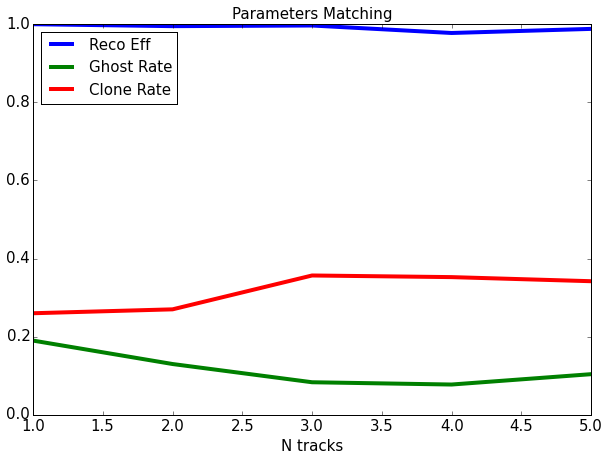

In [324]:
plt.figure(figsize=(10, 7))
plt.plot(n_tracks, results2['PmRecoEff'].values, linewidth=4, label='Reco Eff')
plt.plot(n_tracks, results2['PmGhostRate'].values, linewidth=4, label='Ghost Rate')
plt.plot(n_tracks, results2['PmCloneRate'].values, linewidth=4, label='Clone Rate')
plt.legend(loc='best', prop={'size':15})
plt.xlabel('N tracks', size=15)
plt.xticks(size=15)
plt.yticks(size=15)
plt.title('Parameters Matching', size=15)
plt.show()

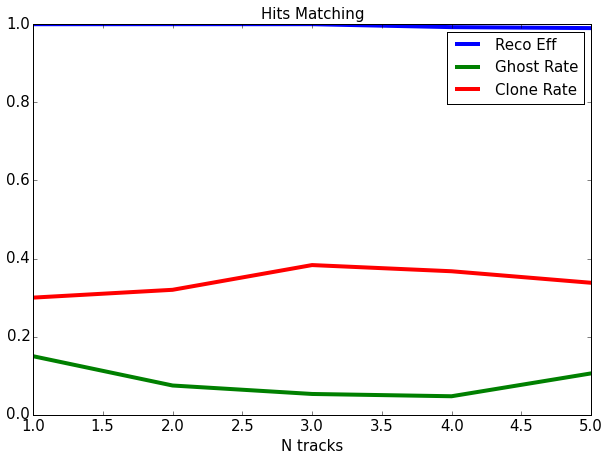

In [325]:
plt.figure(figsize=(10, 7))
plt.plot(n_tracks, results2['HmRecoEff'].values, linewidth=4, label='Reco Eff')
plt.plot(n_tracks, results2['HmGhostRate'].values, linewidth=4, label='Ghost Rate')
plt.plot(n_tracks, results2['HmCloneRate'].values, linewidth=4, label='Clone Rate')
plt.legend(loc='best', prop={'size':15})
plt.xlabel('N tracks', size=15)
plt.xticks(size=15)
plt.yticks(size=15)
plt.title('Hits Matching', size=15)
plt.show()

# Simple Template Matching as Baseline

In [326]:
from TemplateMatching import SimpleTemplateMatching
def get_metrics_baseline(n_events, n_tracks):
    
    events = straight_tracks_generator(n_events=n_events, n_tracks=n_tracks, n_noise=5, sigma=0.01, 
                                       intersection=True, x_range=(0, 10, 1), y_range=(-30, 30, 2))
    
    results = pandas.DataFrame(columns=['EventID', 'HmAvgEff',
                                        'HmRecoEff', 'HmGhostRate', 'HmCloneRate', 
                                        'PmRecoEff', 'PmGhostRate', 'PmCloneRate'])

    for event_id in numpy.unique(events.EventID.values):

        event = events[events.EventID == event_id]
        X = event.X.values.reshape(-1,1)
        y = event.y.values

        stm = SimpleTemplateMatching(8, 1.)
        stm.fit(X, y)
        labels = stm.labels_

        hme = HitsMatchingEfficiency()
        hme.fit(event, labels)

        pme = ParameterMatchingEfficiency(delta_k = 0.2, delta_b=1.0)
        pme.fit(event, labels)

        results.loc[len(results)] = [event_id, hme.avg_efficiency_, 
                                     hme.recognition_efficiency_, hme.ghost_rate_, hme.clone_rate_, 
                                     pme.recognition_efficiency_, pme.ghost_rate_, pme.clone_rate_]
        
    metrics = results[['HmRecoEff', 'HmGhostRate', 'HmCloneRate', 
                       'PmRecoEff', 'PmGhostRate', 'PmCloneRate']].values.mean(axis=0)
    
    return metrics

def get_metrics_dependencies_baseline(n_events, n_tracks):
    
    results = pandas.DataFrame(columns=['HmRecoEff', 'HmGhostRate', 'HmCloneRate', 
                                        'PmRecoEff', 'PmGhostRate', 'PmCloneRate'])
    
    for i in n_tracks:
        
        results.loc[len(results)] = get_metrics_baseline(n_events, i)
        
    return results

In [327]:
results3 = get_metrics_dependencies_baseline(100, n_tracks)
results3.head()

,HmRecoEff,HmGhostRate,HmCloneRate,PmRecoEff,PmGhostRate,PmCloneRate
0,1.0000,0.000000,0,1.000000,0.000,0
1,0.9800,0.000000,0,0.980000,0.000,0
2,0.9400,0.003333,0,0.943333,0.000,0
3,0.8775,0.007500,0,0.880000,0.005,0
4,0.8760,0.004000,0,0.872000,0.008,0


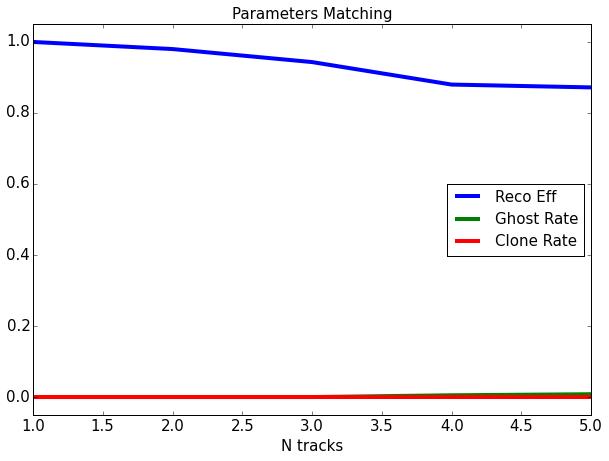

In [328]:
plt.figure(figsize=(10, 7))
plt.plot(n_tracks, results3['PmRecoEff'].values, linewidth=4, label='Reco Eff')
plt.plot(n_tracks, results3['PmGhostRate'].values, linewidth=4, label='Ghost Rate')
plt.plot(n_tracks, results3['PmCloneRate'].values, linewidth=4, label='Clone Rate')
plt.legend(loc='best', prop={'size':15})
plt.xlabel('N tracks', size=15)
plt.xticks(size=15)
plt.yticks(size=15)
plt.ylim(-0.05, 1.05)
plt.title('Parameters Matching', size=15)
plt.show()

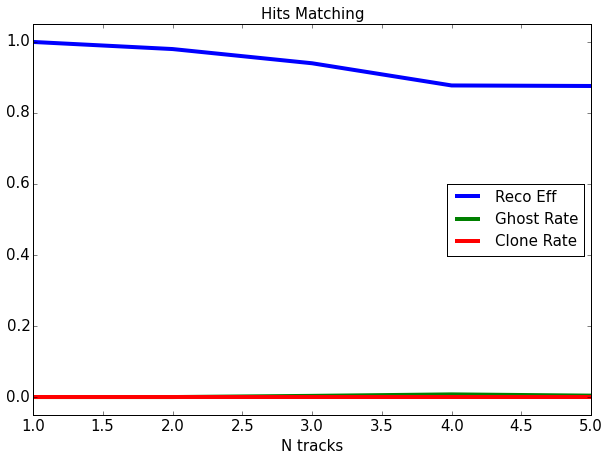

In [329]:
plt.figure(figsize=(10, 7))
plt.plot(n_tracks, results3['HmRecoEff'].values, linewidth=4, label='Reco Eff')
plt.plot(n_tracks, results3['HmGhostRate'].values, linewidth=4, label='Ghost Rate')
plt.plot(n_tracks, results3['HmCloneRate'].values, linewidth=4, label='Clone Rate')
plt.legend(loc='best', prop={'size':15})
plt.xlabel('N tracks', size=15)
plt.xticks(size=15)
plt.yticks(size=15)
plt.ylim(-0.05, 1.05)
plt.title('Hits Matching', size=15)
plt.show()

# DP and Simple Template Matching

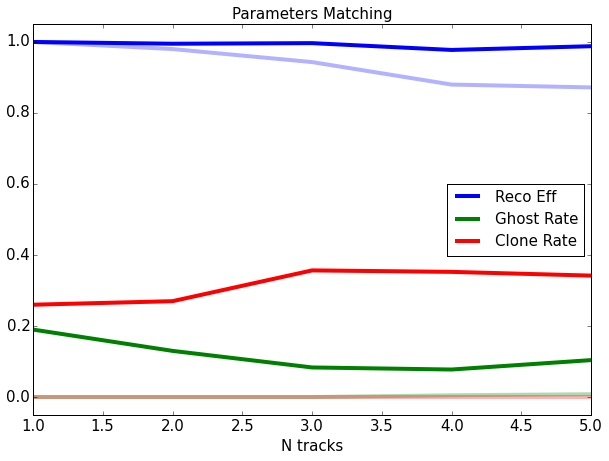

In [330]:
plt.figure(figsize=(10, 7))
plt.plot(n_tracks, results3['PmRecoEff'].values, linewidth=4, alpha=0.3, color='b')
plt.plot(n_tracks, results3['PmGhostRate'].values, linewidth=4, alpha=0.3, color='g')
plt.plot(n_tracks, results3['PmCloneRate'].values, linewidth=4, alpha=0.3, color='r')
plt.plot(n_tracks, results2['PmRecoEff'].values, linewidth=4, label='Reco Eff', color='b')
plt.plot(n_tracks, results2['PmGhostRate'].values, linewidth=4, label='Ghost Rate', color='g')
plt.plot(n_tracks, results2['PmCloneRate'].values, linewidth=4, label='Clone Rate', color='r')
plt.legend(loc='best', prop={'size':15})
plt.xlabel('N tracks', size=15)
plt.xticks(size=15)
plt.yticks(size=15)
plt.ylim(-0.05, 1.05)
plt.title('Parameters Matching', size=15)
plt.show()

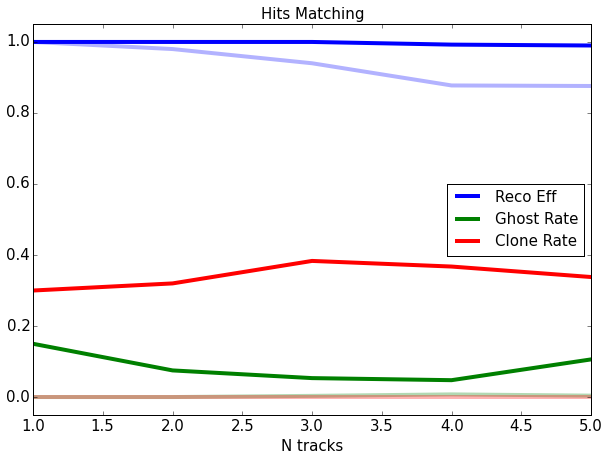

In [331]:
plt.figure(figsize=(10, 7))
plt.plot(n_tracks, results3['HmRecoEff'].values, linewidth=4, alpha=0.3, color='b')
plt.plot(n_tracks, results3['HmGhostRate'].values, linewidth=4, alpha=0.3, color='g')
plt.plot(n_tracks, results3['HmCloneRate'].values, linewidth=4, alpha=0.3, color='r')
plt.plot(n_tracks, results2['HmRecoEff'].values, linewidth=4, label='Reco Eff', color='b')
plt.plot(n_tracks, results2['HmGhostRate'].values, linewidth=4, label='Ghost Rate', color='g')
plt.plot(n_tracks, results2['HmCloneRate'].values, linewidth=4, label='Clone Rate', color='r')
plt.legend(loc='best', prop={'size':15})
plt.xlabel('N tracks', size=15)
plt.xticks(size=15)
plt.yticks(size=15)
plt.ylim(-0.05, 1.05)
plt.title('Hits Matching', size=15)
plt.show()